# [E-16] 흐린 사진을 선명하게

# 0. 시작하기전 

시작하기전 super resolution에 대한 개념을 알아보도럭

## Super Resolution

### Resolution

### Super Resloution Method

#### 1. interpolation
- linear interpolation
- Bilinear interpolation

#### 2. SRCNN

#### 3. SRCAN

# Project 1

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

## Project 1-1 
높은 해상도의 사진 -> 저해상도 사진 -> 
1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. cv2.resize()를 사용해 봅시다.
3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.
4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 cv2.resize()를 사용해 봅시다.
5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

(2880, 1920, 3)


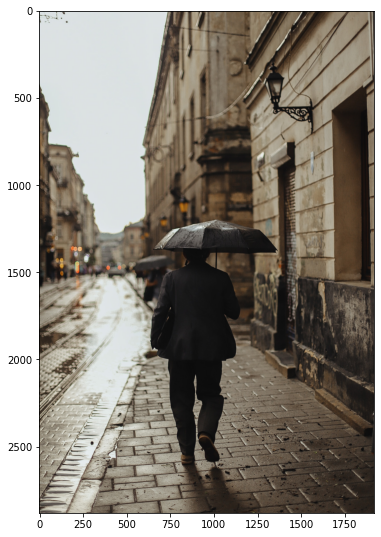

In [32]:
# 고해상도 이미지 불러오기
hr_image = cv2.imread(os.getenv('HOME') + '/aiffel/super_resolution/large_fig.jpg')
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

print(hr_image.shape)

plt.figure(figsize=(6,15))
plt.imshow(hr_image)

(720, 480, 3)


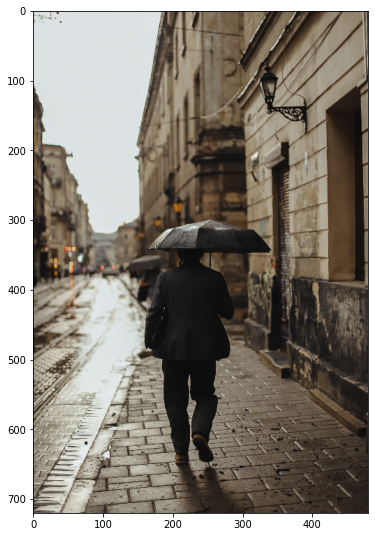

In [33]:
# 이미지 사이즈 줄이기
lr_image = cv2.resize(
    hr_image,
    dsize=(hr_image.shape[1]//4, hr_image.shape[0]//4)
)

print(lr_image.shape)

plt.figure(figsize=(6,15))
plt.imshow(lr_image)

In [34]:
# pre-trained 모델 로드
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file, compile=False)

In [35]:
# SRGAN으로 고해상도 이미지 생성
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]



srgan_hr = apply_srgan(lr_image)

In [38]:
# bicubic interpolation으로 이미지 사이즈 키우기
bicubic_hr = cv2.resize(
    lr_image,
    dsize=(hr_image.shape[1], hr_image.shape[0]), # 고해상도 이미지 크기로 설정
    #interpolation=cv2.INTER_CUBIC # bicubic 설정
)

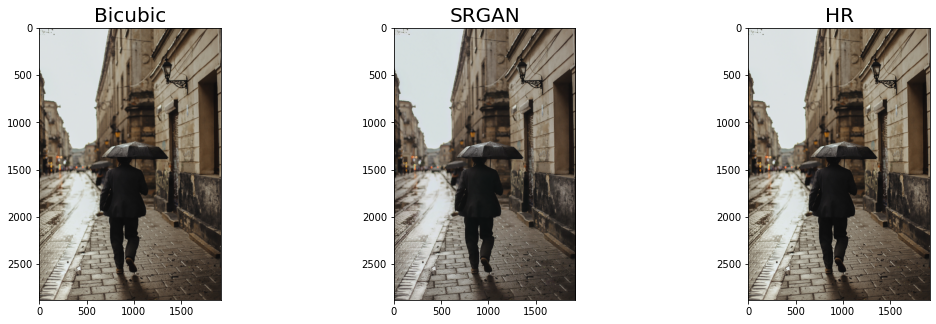

In [39]:
# 시각화
images = [bicubic_hr, srgan_hr, hr_image]
titles = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize=(18,5))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

In [40]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

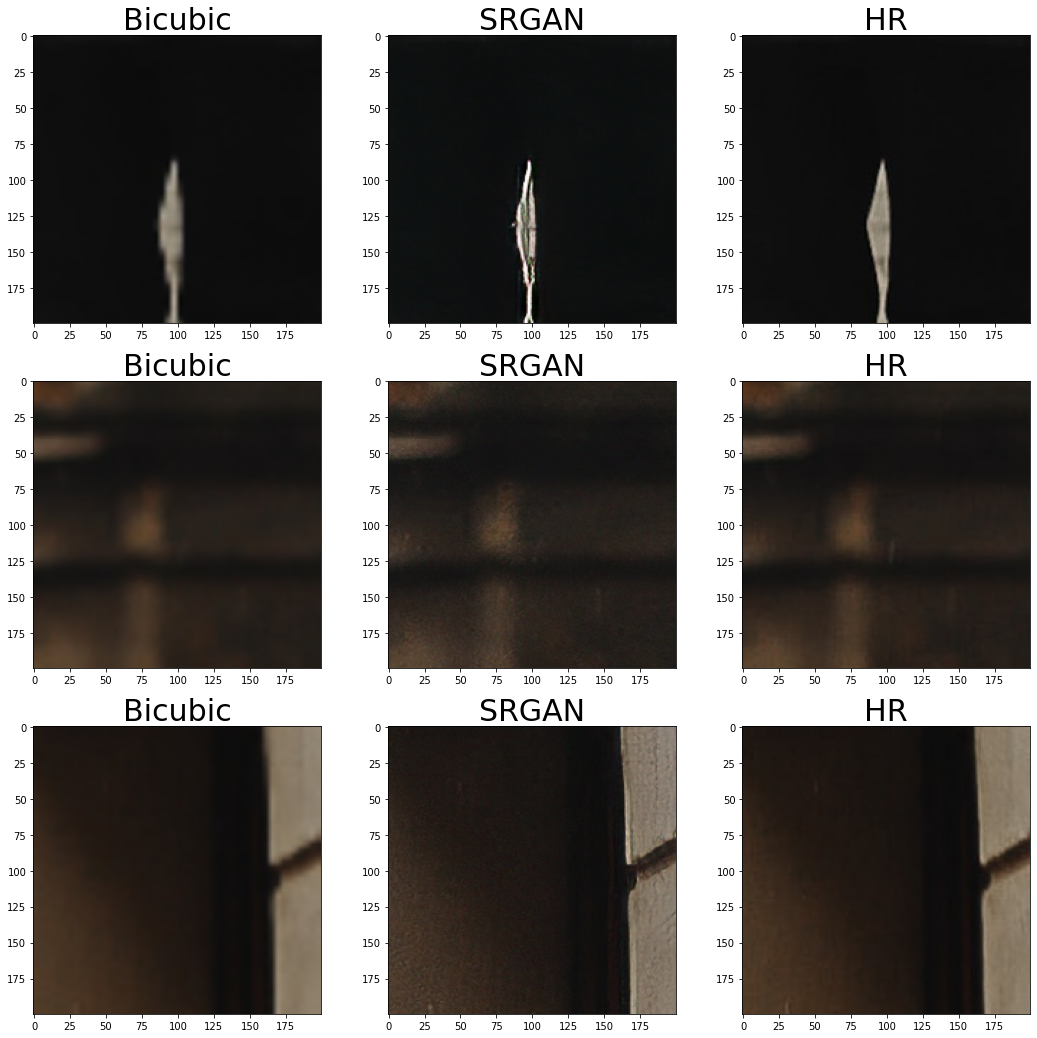

In [44]:
1920
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(2000,800), (800,1000), (600,1720)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(hr_image, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

## 1-2